# SVM (Support Vector Machines)

## Objectives:
After completing this lab you will be able to:

*   Use scikit-learn to Support Vector Machine to classify


In this notebook, we will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.


#### Import required libraries 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.optimize as opt 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

## Load the cancer data 
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |


### Load the data from CSV 

In [35]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/cell_samples.csv"
cell_df = pd.read_csv(url)
cell_df.head(8)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

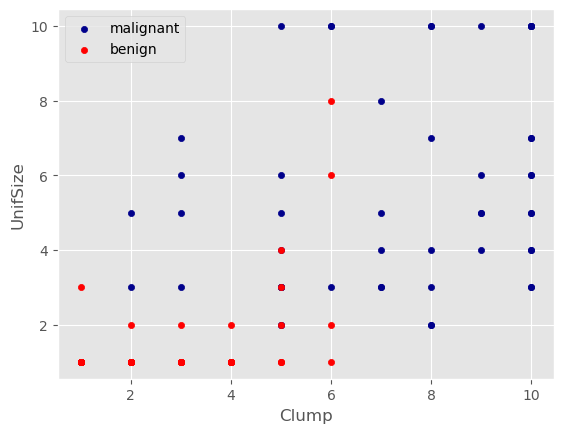

In [36]:
ax = cell_df[cell_df['Class']==4][0:50].plot(kind='scatter',
                                            x = 'Clump',
                                            y= 'UnifSize',
                                            color = 'DarkBlue',
                                            label = 'malignant'
                                            ) ;
cell_df[cell_df['Class']==2][0:50].plot(kind='scatter',
                                        x='Clump',
                                        y='UnifSize',
                                        color = 'Red',
                                        label = 'benign',
                                        ax=ax);


## Data pre-processing and selection 

Examine column data types :

In [37]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [38]:
cell_df['BareNuc'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: BareNuc, dtype: int64

`BareNuc` column includes some values that are not numerical. We can drop these rows 

In [39]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce' ).notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [40]:
# check for missing values 
cell_df.isnull().sum()

ID             0
Clump          0
UnifSize       0
UnifShape      0
MargAdh        0
SingEpiSize    0
BareNuc        0
BlandChrom     0
NormNucl       0
Mit            0
Class          0
dtype: int64

we see that there are no missing values in our dataset 

#### Divide features and target from the dataset:


As we have seen from the description of Dataset columns 'Clump' - 'Mit' are features 

In [41]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape',
                       'MargAdh', 'SingEpiSize', 'BareNuc', 
                       'BlandChrom', 'NormNucl', 'Mit']]
#feature matrix 
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [43]:
# target vector
y = np.asanyarray(cell_df['Class'])
y[:5]

array([2, 2, 2, 2, 2], dtype=int64)

### Train / Test Dataset:

Split the data to train and test sets:

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


## Modeling with Scikit-learn

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [46]:
from sklearn import svm
#radial basis function- 'rbf'
svm_classification = svm.SVC(kernel='rbf')
svm_classification.fit(X_train, y_train)

SVC()

After being fitted, the model can be used to predict new values :

In [47]:
y_hat = svm_classification.predict(X_test)
y_hat[0:5]

array([2, 4, 2, 4, 2], dtype=int64)

### Evaluation 

1. jaccard index for accuracy 

In [48]:
from sklearn.metrics import jaccard_score
j_score = jaccard_score(y_test, y_hat, pos_label=2)
print("Jaccard score: ", j_score)

Jaccard score:  0.9444444444444444


2. f1_score:

In [49]:
from sklearn.metrics import f1_score
f1_scr = f1_score(y_test, y_hat, average='weighted')
print("f1_score : ", f1_scr)

f1_score :  0.9639038982104676


3. Confusion matrix

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                        normalize=False, 
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


compute confusion matrix and classification report

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


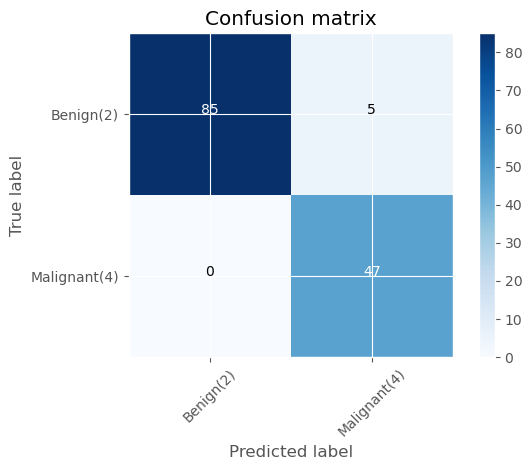

In [52]:
cnf_matrix = confusion_matrix(y_test, y_hat, labels=[2,4])
np.set_printoptions(precision=2)

print(classification_report(y_test, y_hat))

#plot non normalized confusion matrix 

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)', 'Malignant(4)'],
                      normalize=False, title='Confusion matrix')

## SVM model with linear kernel

In [53]:
clf_lin = svm.SVC(kernel='linear')
clf_lin.fit(X_train, y_train)
y_hat2 = clf_lin.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, y_hat2, average='weighted'))
print("Jaccard score: %.4f" % jaccard_score(y_test, y_hat2,pos_label=2))

Avg F1-score: 0.9639
Jaccard score: 0.9444
